# wavelet-partition
tool to partition FLUXNET-CH4 data into diffusive and ebullitive fluxes

In [93]:
import pandas as pd
import numpy as np
import pywt
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

set global matplotlib settings

In [94]:
plt.style.use('ggplot')
# text_kwargs = dict(ha='center', va='center', fontsize=28, color='C1') # global plotting settings

## Import data and process

FLUXNET-CH4 data stored on google drive, split google drive url and import with pandas

In [95]:
url = "https://drive.google.com/file/d/1Pudof9T3_TOxpd5eY2F9ZjyvGxFub4Rg/view?usp=sharing"
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
df = pd.read_csv(dwn_url)

select all rows from selected columns

In [96]:
df = df.loc[:, ["TIMESTAMP_START", "LE", "FCH4", "TA", "FCH4_F", "TA_F"]]

replace missing with nan, forward-pad nans to new column "FCH4_P"

In [110]:
df = df.replace(-9999, np.nan)
for i in range(10):
    df['FCH4_P{}'.format(i+1)] = df["FCH4"].fillna(method="pad", limit=i+1)

parse timestamp to new column "date"

In [98]:
df["date"] = pd.to_datetime(df["TIMESTAMP_START"], format='%Y%m%d%H%M')

### Find portion to partition

plot entire FCH4 series vs time

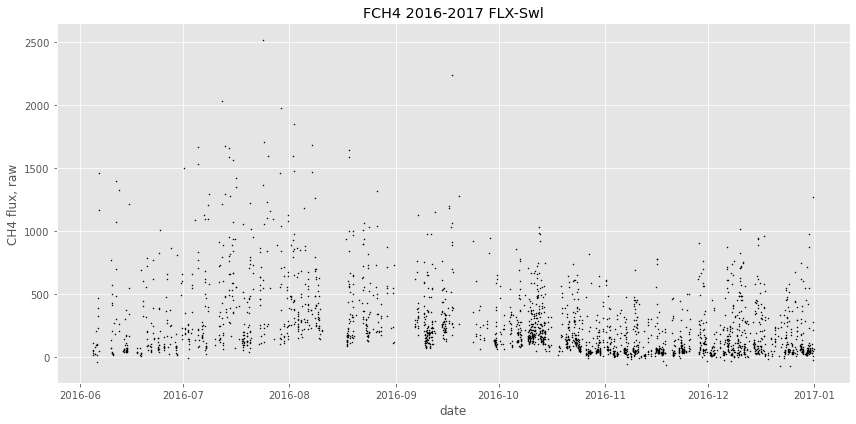

In [99]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df['date'], df['FCH4'], c='k', s=1)
ax.set_ylabel("CH4 flux, raw")
ax.set_xlabel("date")
ax.set_title("FCH4 2016-2017 FLX-Swl")
plt.tight_layout()

limit date range, into new Dataframe data

(roughly 2016-06-01 to 2016-08-15 looks relatively continuous)

In [100]:
dfw = df[((df['date'] >= '2016-01-01') & (df['date'] <= '2016-08-11'))]

plot FCH4 and FCH4_F

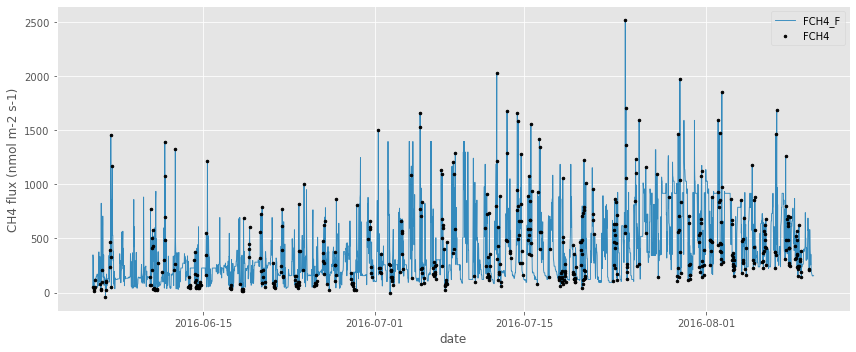

In [101]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(dfw['date'], dfw['FCH4_F'], list(plt.rcParams['axes.prop_cycle'])[1]['color'], 
        dfw['date'], dfw['FCH4'], 'k.', markersize=5, linewidth=0.9)
ax.set_xlabel('date')
ax.set_ylabel('CH4 flux (nmol m-2 s-1)')
ax.legend(['FCH4_F', 'FCH4']) # not sure why this order, this is workaround
plt.tight_layout()

gap-filling is adding some serious fluctuations in gaps of seemingly days? I want to trim that big gap ~06-06 to 06-09 and pad with pandas

better way to zoom would be to find first non-nan value in FCH4 vector and corresponding date

edit: Series.first_valid_index() returns index of first non-nan (.last_... returns last)

In [111]:
dfw = df[df['FCH4'][df['date'] >= '2016-06-08'].first_valid_index():df['FCH4'][df['date'] <= '2016-08-15'].last_valid_index()]

plot all padded series

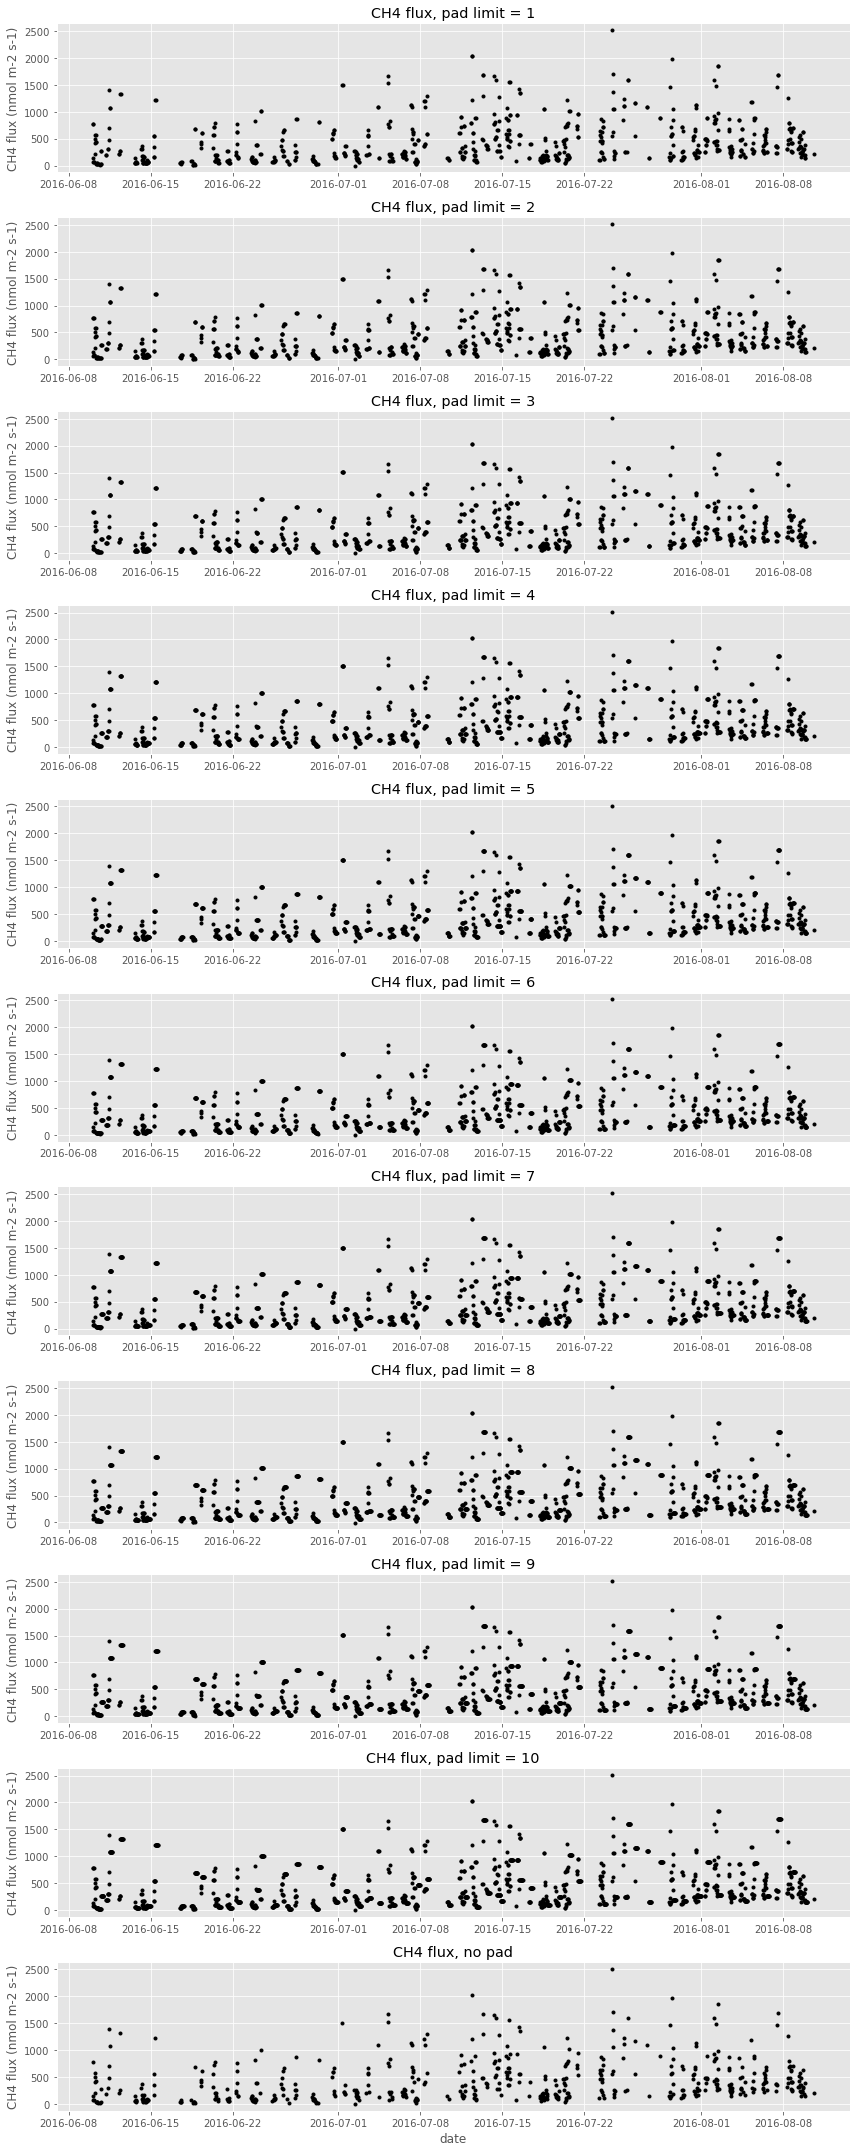

In [116]:
fig, ax = plt.subplots(11, 1, sharey=True, figsize=(12,30))

for i in range(10):
    ax[i].plot(dfw['date'], dfw['FCH4_P{}'.format(i+1)], 'k.')
    ax[i].set_title('CH4 flux, pad limit = {}'.format(i+1))
    ax[i].set_ylabel('CH4 flux (nmol m-2 s-1)')

ax[10].plot(dfw['date'], dfw['FCH4'], 'k.')
ax[10].set_title('CH4 flux, no pad')
ax[10].set_xlabel('date')
ax[10].set_ylabel('CH4 flux (nmol m-2 s-1)')
plt.tight_layout()

misguided? defunct? find continuous measurements, group_by cumsum of isna(), bigger groups are longer continuous chunks


In [92]:
# dfw['group_no'] = dfw['FCH4'].isna().cumsum()

# dfg = df.groupby('group_no').filter(lambda x: len(x) == 1)
# d = {i: df.loc[df.group_no == i, ['date', 'FCH4']] 
#      for i in range(1, df.group_no.iat[-1])}
# # ds = pd.DataFrame(d)

plot histogram of gap lengths for different pad limits

# junk / test

scatter FCH4_F and FCH4 vs time

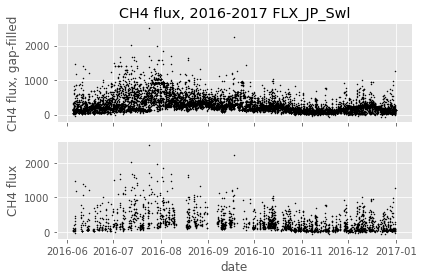

In [89]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)
ax[0].scatter(df['date'], df['FCH4_F'], c='k', s=1)
ax[0].set_ylabel("CH4 flux, gap-filled")
ax[0].set_title("CH4 flux, 2016-2017 FLX_JP_Swl")

ax[1].scatter(df['date'], df['FCH4'], c='k', s=1)
ax[1].set_ylabel("CH4 flux")
ax[1].set_xlabel("date")
plt.tight_layout()

compute wavelet transform on gap-filled data

In [6]:
cM = pd.DataFrame(pywt.wavedec(df['FCH4_F'], 'haar')).transpose()
cT = pd.DataFrame(pywt.wavedec(df['TA_F'], 'haar')).transpose()

scatter of wavelet coefficients

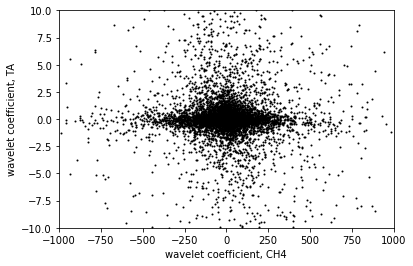

In [142]:
fig, ax = plt.subplots()

for i in range(cM.shape[1]):
    ax.scatter(cM[i], cT[i], c='k', s=1)
plt.xlabel("wavelet coefficient, CH4")
plt.ylabel("wavelet coefficient, TA")
plt.xlim(-1000, 1000)
plt.ylim(-10, 10)
plt.show()

scatter of FCH4 and TA vs time

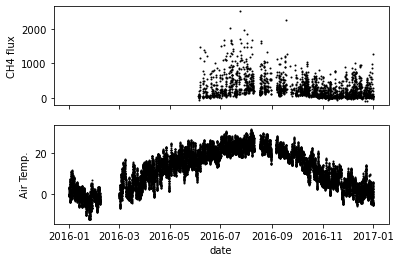

In [143]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=False)

axs[0].scatter(df['date'], df['FCH4'], c='k', s=1)
axs[0].set_ylabel('CH4 flux')

axs[1].scatter(df['date'], df['TA'], c='k', s=1)
axs[1].set_ylabel('Air Temp.')
axs[1].set_xlabel('date')
plt.show()